<a href="https://colab.research.google.com/github/Tower5954/TensorFlow/blob/main/04_Transfer_learning_in_tensorflow_part_1_feature_extraction_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 1: Feature extraction.

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are 2 main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Wed Dec 15 06:25:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data.



In [2]:
# Get data (10% of 10 food classes from Food101)

import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2021-12-15 06:25:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   141MB/s    in 1.1s    

2021-12-15 06:25:40 (141 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are: {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' ")

There are: 2 directories and 0 images in '10_food_classes_10_percent' 
There are: 10 directories and 0 images in '10_food_classes_10_percent/test' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/ramen' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/sushi' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice' 
There are: 0 directories and 250 images in '10_food_classes_10_percent/test/steak' 
There are: 0 directories and 250 images in '10_food_classe

## Create data loaders (preparing the data)

We will use the `ImageDataGenerator` class to load in our images in batches 

In [4]:
# Set up data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = (32)

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")


print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while the model trains)

Callbacks are extra functionality you can add to a model to be performed during or after training. Some of the more popular callbacks are:
* Tracking experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.





In [5]:
# Create TensorBoard callback (functionised to allow for creating a new one for each model)

In [6]:
import datetime
import tensorflow as tf


def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" +experiment_name + "/" + datetime.datetime.now().strftime('%d%m%Y-%H%M')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

🔑 **Note**: 🔑 You can customise the directory where your TensorBoard logs(model training metrics)gets saved to wherever you like. The `log_dir` parameter created above is just one option. 

## Creating models using TensorFlow Hub


In the past we have used TensorFlow to create our own models layer by layer from scratch.

Now we are going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

🔑 Note: Comparing different model architecture performance on the same data is a very common practice. The simple reason is because you want to know which model performs best for your problem.

Update: As of 14 August 2021, EfficientNet V2 pretrained models are available on TensorFlow Hub. The original code in this notebook uses EfficientNet V1, it has been left unchanged. In my experiments with this dataset, V1 outperforms V2. Best to experiment with your own data and see what suits you.

In [7]:
# Comparing the following models:


# Resnet 50 V2 feature vector
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
# import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
import matplotlib.pyplot as plt

In [9]:
# Create a make_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a keras Sequential model with it.

  Args: 
      model_url (str): A Tensorflow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default is 10.

  Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor 
      layer and dense output layer with num_classes output neurons. 
  """
  # Download the pretrained model and save it as a kera slayer
  feature_extracor_layer = hub.KerasLayer(model_url,
                                          trainable=False, # Freeze the already trained patterns.
                                          name='feature_extraction_layer',
                                          input_shape=IMAGE_SHAPE + (3,)) 
  
  # Create a model
  model = tf.keras.Sequential([
                  feature_extracor_layer,
                  layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])


  return model



### Creating and Testing a **ResNet** TensorFlow Hub Feature Extraction model





In [10]:
resnet_model = create_model(resnet_url)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
from tensorflow.python.util.dispatch import dispatch_for_unary_elementwise_apis
# Fitting the ResNet model to the data (10 percent of 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/15122021-0625
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 1.8649 - accuracy: 0.3813 - val_loss: 1.1588 - val_accuracy: 0.6424
Epoch 2/5
24/24 [==============================] - 23s 1s/step - loss: 0.9034 - accuracy: 0.7453 - val_loss: 0.8401 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 22s 934ms/step - loss: 0.6140 - accuracy: 0.8240 - val_loss: 0.7351 - val_accuracy: 0.7616
Epoch 4/5
24/24 [==============================] - 22s 943ms/step - loss: 0.4643 - accuracy: 0.8813 - val_loss: 0.6778 - val_accuracy: 0.7820
Epoch 5/5
24/24 [==============================] - 21s 911ms/step - loss: 0.3739 - accuracy: 0.9213 - val_loss: 0.6596 - val_accuracy: 0.7864


The transfer learning feature extractor model out performed all previous models
we built by hand and in a quicker training time and with only 10%
of the training examples.

In [14]:
# Create a function to plot loss curves.

def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
      history: TensorFlow History object.

  Returns:
      Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.plot(epochs,loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

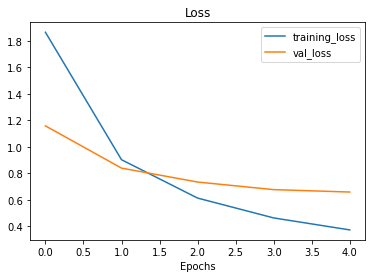

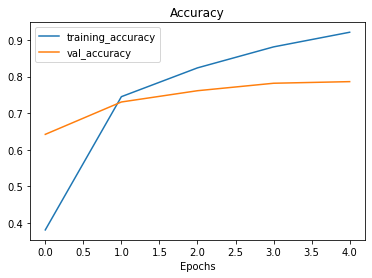

In [15]:
plot_loss_curves(resnet_history)

### Creating and Testing a **EfficientNetB0** TensorFlow Hub Feature Extraction model

In [16]:
# Create EffecientNetB0 feature extractor model

efficientnet_model = create_model(model_url=efficientnet_url)

# Compile the model 

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the model to 10% of the training data
efficient_history = efficientnet_model.fit(train_data_10_percent,
                                           epochs=5,
                                           steps_per_epoch=(len(train_data_10_percent)),
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetB0")]
                                           )

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/15122021-0628
Epoch 1/5
24/24 [==============================] - 32s 888ms/step - loss: 1.8591 - accuracy: 0.4333 - val_loss: 1.2909 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 19s 831ms/step - loss: 1.0658 - accuracy: 0.7787 - val_loss: 0.8694 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 19s 801ms/step - loss: 0.7570 - accuracy: 0.8480 - val_loss: 0.7015 - val_accuracy: 0.8400
Epoch 4/5
24/24 [==============================] - 18s 784ms/step - loss: 0.6118 - accuracy: 0.8720 - val_loss: 0.6107 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 18s 792ms/step - loss: 0.5170 - accuracy: 0.8907 - val_loss: 0.5580 - val_accuracy: 0.8624


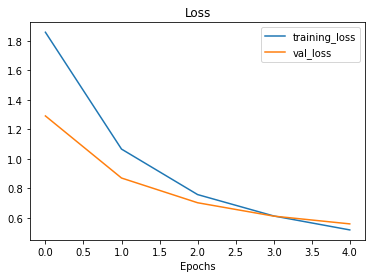

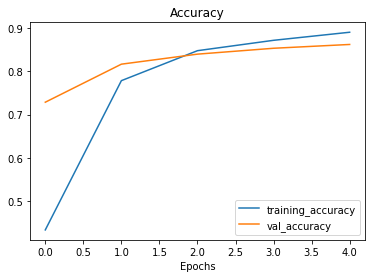

In [17]:
plot_loss_curves(efficient_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [20]:
# How many layers doess the effcientnet_model have?
len(efficientnet_model.layers[0].weights)

309

## Different types of Transfer learning

* **"As is" transfer learning** - using an exisisting model with no changes (e.g. using ImageNet model on 1000 ImageNet classes)
* **"Feature extraction" transfer learning** - use the prelearned patterns of a pretrained model (e.g. EffecientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food).
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an exisiting model and "fine-tune" many or all of the underlying layers (including new output layers). 

## Comparing the models results using TensorBoard

> 🔑 **Note**: 🔑 When uploading to TensorBoard.dev, you are making your experiments public. 